<a href="https://colab.research.google.com/github/dnhshl/cc-ai/blob/main/simpleRobot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# simpleRobot
Neuronales Netz zur Berechnung der inversen Kinematik eines (sehr einfachen) Roboters mit zwei Freiheitsgraden.





## Lade notwendige Libraries


In [2]:
#!pip install keras_sequential_ascii

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import optimizers
import matplotlib.pyplot as plt

import tensorflow.keras.backend as kb

#from keras_sequential_ascii import keras2ascii



# Daten

Generiere Trainingsdaten. Das ist hier sehr einfach, da bei bekannten Winkeln `phi1` und `phi2` die `x` und `y` Position berechnet werden kann. 

Der Einfachheit halber (um auszuschließen, dass gleiche Positionen mit unterschiedlichen Winkelstellungen angefahren werden können) wird `phi1` auf 0 .. 90 Grad und `phi2` auf -90 .. 0 Grad eingeschränkt.

## Vorab: Vektoren und Matrizen in numpy

In [ ]:
a = np.array([1,2,3]) # Zeilenvektor a
b = np.array([4,5,6]) # Zeilenvektor b

M = np.vstack((a, b)) # Zusammenfassen als 2x3 Matrix

M = M.T # Transponieren -> 3x2 Matrix

print(a, b)
print(M)

sum_a_b = M.sum(axis=1) # Summe der Spaltenvektoren
print(sum_a_b)

[1 2 3] [4 5 6]
[[1 4]
 [2 5]
 [3 6]]
[5 7 9]


## OK, jetzt also die Trainingsdaten

In [36]:
l1 = 0.3  # Länge des ersten Roboterarms
l2 = 0.3  # Länge des zweiten Roboterarms

traindatasize = 1000000 # Wie viele Traingsdaten sollen generiert werden?


def gen_data(size):

  # phi1 im Bereich von -90 .. 0 Grad 
  q1 = -np.random.random_sample(size) * np.pi/2

  # phi2 im Bereich von 0 .. 90 Grad 
  q2 = np.random.random_sample(size) * np.pi/2

  # Kombiniere Vektoren als Matrix
  dout = np.vstack((q1, q2)).T

  # Berechne x und y
  din = np.array([l1 * np.cos(dout[:,0]) + l2 * np.cos(dout.sum(axis=1)), 
                  l1 * np.sin(dout[:,0]) + l2 * np.sin(dout.sum(axis=1))]).T 

  _, unique = np.unique(din.round(decimals=3), return_index=True, axis=0) 
  #print(unique)

  #print(din.round(decimals=3))


  return (din[unique], dout[unique])



(din, dout) = gen_data(traindatasize)
#print(din)

print(din.shape)

somedata = np.random.choice(dout.shape[0], 5)

print(dout[somedata]*180/np.pi)
print(din[somedata])





(141745, 2)
[[-32.52823654  76.3644451 ]
 [-33.57433638  32.82768575]
 [-25.16004081  24.6528563 ]
 [-46.64602569  63.79204294]
 [-89.3549745   55.9767189 ]]
[[ 0.46933477  0.04646519]
 [ 0.54992524 -0.16981487]
 [ 0.57152538 -0.13020002]
 [ 0.49261805 -0.12969555]
 [ 0.25389429 -0.46503015]]


## Welcher Bereich `(x, y)` kann vom Roboter erreicht werden?

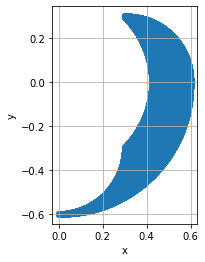

In [ ]:

def plot_range():
  plt.scatter(din[:,0], din[:,1])
  plt.xlabel('x')
  plt.ylabel('y')
  #plt.xlim(0,2.5)
  plt.grid(True)
  plt.gca().set_aspect("equal")


plot_range()

# NN

Zwei Fully Connected Layer, der erste Layer mit Aktivierungsfunktion.

Als Fehlerfunktion wird der quadratische Fehler genutzt. Sie können auch [andere Loss Functions](https://keras.io/api/losses/) ausprobieren.

Testen Sie auch verschiedene [Optimizer](https://keras.io/api/optimizers/) .

## Hyperparameter

In [57]:
# Netzwerkparameter

layer1size = 30
layer2size = 20

# Trainingsparameter

myoptimizer = optimizers.Adam
learning_rate = 0.001
batch_size = 50
epochs = 10

In [47]:
def forward_kinematics(q):

  x = l1*tf.cos(q[:,0]) +l2*tf.cos(tf.reduce_sum(q,1))
  y = l1*tf.sin(q[:,0]) +l2*tf.sin(tf.reduce_sum(q,1))
  return tf.stack((x, y), axis=1)


In [77]:
def myloss(y_true,y_pred):

  in_true = forward_kinematics(y_true)
  in_pred = forward_kinematics(y_pred)

  return kb.mean(kb.square(in_true - in_pred) + 0.1* kb.square(y_true - y_pred))


## Konstruiere NN

In [78]:
def build_and_compile_model():
  model = keras.Sequential([
      layers.Dense(layer1size, input_shape=[2,], activation='tanh', kernel_initializer='he_uniform'),
      layers.Dense(layer2size, activation='tanh',  kernel_initializer='he_uniform'),
      #layers.Dense(layer2size, activation='relu',  kernel_initializer='he_uniform'),
      layers.Dense(2, kernel_initializer='he_uniform')     ## output
  ])

  model.compile(loss=myloss,
                optimizer=myoptimizer(learning_rate=0.01))
  return model

In [79]:
mymodel = build_and_compile_model()
mymodel.summary()

print()
print('________________________')
print('NN Struktur in Ascii Art')
print('________________________')
print()

#keras2ascii(mymodel)


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 30)                90        
_________________________________________________________________
dense_19 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 42        
Total params: 752
Trainable params: 752
Non-trainable params: 0
_________________________________________________________________

________________________
NN Struktur in Ascii Art
________________________



## Trainiere Modell

Nutze 20% der Testdaten als Validierungsdatensatz

In [80]:


history = mymodel.fit(din, dout,
          batch_size=batch_size, epochs=epochs,
          validation_split = 0.2)

Epoch 1/10
2268/2268 [==============================] - 7s 3ms/step - loss: 0.0047 - val_loss: 0.0016
Epoch 2/10
2268/2268 [==============================] - 6s 3ms/step - loss: 1.2753e-04 - val_loss: 0.0011
Epoch 3/10
2268/2268 [==============================] - 6s 3ms/step - loss: 9.6866e-05 - val_loss: 0.0020
Epoch 4/10
2268/2268 [==============================] - 6s 3ms/step - loss: 8.7931e-05 - val_loss: 0.0014
Epoch 5/10
2268/2268 [==============================] - 6s 3ms/step - loss: 6.7273e-05 - val_loss: 0.0011
Epoch 6/10
2268/2268 [==============================] - 6s 3ms/step - loss: 6.1343e-05 - val_loss: 0.0014
Epoch 7/10
2268/2268 [==============================] - 6s 3ms/step - loss: 5.6350e-05 - val_loss: 0.0014
Epoch 8/10
2268/2268 [==============================] - 6s 3ms/step - loss: 4.3822e-05 - val_loss: 0.0011
Epoch 9/10
2268/2268 [==============================] - 6s 3ms/step - loss: 4.2921e-05 - val_loss: 0.0014
Epoch 10/10
2268/2268 [===========================

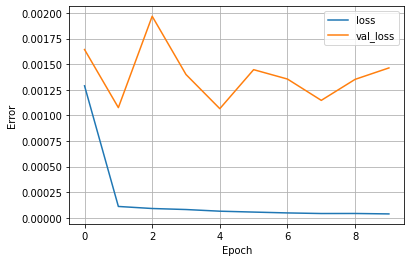

In [81]:


def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

## Teste trainiertes Modell

In [82]:
testdatasize = 10000

(testdata_in, testdata_out) = gen_data(testdatasize)

print(testdata_in.shape)

predictions = mymodel.predict(testdata_in)

somedata = np.random.choice(predictions.shape[0], 5)

for d in somedata:
  print(predictions[d]*180/np.pi, testdata_out[d]*180/np.pi)

tf.print(forward_kinematics(predictions[somedata]))

tf.print(forward_kinematics(testdata_out[somedata]))

error = mymodel.evaluate(testdata_in, testdata_out, verbose=1)
print(np.sqrt(error))

(9442, 2)
[-83.347374  14.384424] [-83.23284203  14.80527832]
[-31.401402  42.890305] [-29.44293409  39.68810063]
[-61.98447  88.67522] [-62.09758687  89.53676757]
[-20.43985  39.16921] [-14.85706238  28.2220551 ]
[-84.22891   74.060776] [-83.5566789   74.26544467]
[[0.142446309 -0.577984571]
 [0.550050437 -0.0965557396]
 [0.408946455 -0.130093694]
 [0.565225601 -0.00843767822]
 [0.325454473 -0.351440728]]
[[0.14565359850383472 -0.57689600671826269]
 [0.55647042527138746 -0.094108776257704418]
 [0.40664025409356686 -0.12688173827076002]
 [0.58184573903817638 -0.0075765043400146947]
 [0.32973021389229445 -0.34654085774684751]]
296/296 [==============================] - 0s 1ms/step - loss: 8.2743e-04
0.028765097004130873


## Teste verschiedene Trajektorien

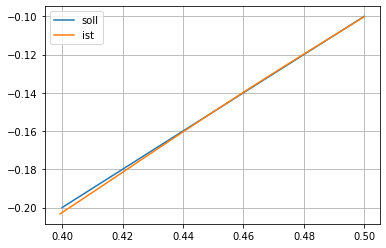

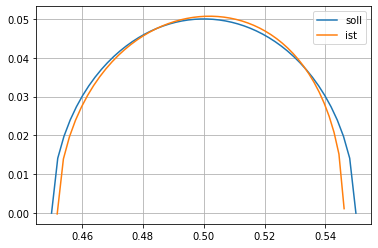

In [83]:
# Gerade

xtest1 = np.linspace(0.4,0.5)
ytest1 = (xtest1-0.4) -0.2

# Parabel
#xtest2 = np.linspace(1, 1.8)
#ytest2 = -0.5*xtest2*xtest2 +2

# Kreisbogen
xtest3 = np.linspace(-0.05, 0.05)
ytest3 = np.sqrt(0.05*0.05 - xtest3*xtest3)
xtest3 = xtest3 + 0.5
ytest3 = ytest3 


def plot_trajectory(x, y):
  plt.figure()
  plt.plot(x,y, label='soll')
  phipred = mymodel.predict(np.vstack((x, y)).T)

  # Berechne x und y
  xpred = l1 * np.cos(phipred[:,0]) + l2 * np.cos(phipred.sum(axis=1))
  ypred = l1 * np.sin(phipred[:,0]) + l2 * np.sin(phipred.sum(axis=1))

  pred = forward_kinematics(mymodel.predict(np.vstack((x, y)).T))

  plt.plot(pred[:,0], pred[:,1], label='ist')
  plt.grid(True)
  plt.legend()


plot_trajectory(xtest1, ytest1)

#plot_trajectory(xtest2, ytest2)

plot_trajectory(xtest3, ytest3)

